In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 5) remove checkpoints
# import os; _ = [os.remove(p) for p in __import__("glob").glob("libs/.ipynb_checkpoints/*.py") if os.path.exists(p)]

import importlib
from libs import trades, plots, params, feats, strategies, models_core
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strategies)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)

# df = df_trainval # SELECT THE CORRECT DATAFRAME
# df.close.plot()
# df

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds_trainval = pd.read_csv(params.indunsc_test_csv, index_col=0, parse_dates=True) ############### (it should be the indunsc_trainval_csv)
df_inds_trainval = df_inds_trainval[(df_inds_trainval.index >= '2023-06-20') & (df_inds_trainval.index < '2024-05-10')] #########################
# df_inds_trainval = df_inds_trainval[df_inds_trainval.index.to_period("M") == params.month_to_check] ################################

# compute synthetic ask/bid from close_raw and configured spread
df_inds_trainval['ask'] = df_inds_trainval['close'] * (1 + params.bidask_spread_pct/100)
df_inds_trainval['bid'] = df_inds_trainval['close'] * (1 - params.bidask_spread_pct/100)

df = df_inds_trainval # SELECT THE CORRECT DATAFRAME
df.close.plot()
df

,open,high,low,close,volume,signal,ret,log_ret,sma_9,sma_21,sma_pct_9,sma_pct_21,ema_9,ema_21,roc_9,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,macd_line,macd_signal,macd_diff,atr_14,atr_pct_14,bb_lband_20,bb_hband_20,bb_w_20,plus_di,minus_di,adx,obv,vwap_14,vwap_dev_pct_14,vol_spike,vol_z_14,rolling_max_close_21,rolling_min_close_21,dist_high_21,dist_low_21,obv_sma,obv_diff_14,obv_pct_14,obv_sma_14,obv_z_14,ret_30,sma_30,sma_pct_30,ema_30,roc_30,rsi_30,atr_30,atr_pct_30,bb_lband_30,bb_hband_30,bb_w_30,plus_di_30,minus_di_30,adx_30,obv_diff_30,obv_pct_30,obv_sma_30,obv_z_30,vwap_30,vwap_dev_pct_30,z_vwap_dev_30,vol_spike_30,vol_z_30,ret_std_30,rolling_max_close_30,rolling_min_close_30,dist_high_30,dist_low_30,macd_line_30,macd_signal_30,macd_diff_30,ret_45,sma_45,sma_pct_45,ema_45,roc_45,rsi_45,atr_45,atr_pct_45,bb_lband_45,bb_hband_45,bb_w_45,plus_di_45,minus_di_45,adx_45,obv_diff_45,obv_pct_45,obv_sma_45,obv_z_45,vwap_45,vwap_dev_pct_45,z_vwap_dev_45,vol_spike_45,vol_z_45,ret_std_45,rolling_max_close_45,rolling_min_close_45,dist_high_45,dist_low_45,macd_line_45,macd_signal_45,macd_diff_45,ret_60,sma_60,sma_pct_60,ema_60,roc_60,rsi_60,atr_60,atr_pct_60,bb_lband_60,bb_hband_60,bb_w_60,plus_di_60,minus_di_60,adx_60,obv_diff_60,obv_pct_60,obv_sma_60,obv_z_60,vwap_60,vwap_dev_pct_60,z_vwap_dev_60,vol_spike_60,vol_z_60,ret_std_60,rolling_max_close_60,rolling_min_close_60,dist_high_60,dist_low_60,macd_line_60,macd_signal_60,macd_diff_60,volume_z_30,vol_spike_z_30,ret_std_z_30,obv_pct_z_30,vwap_dev_pct_z_30,bb_w_z_30,atr_z_30,macd_diff_z_30,volume_z_45,vol_spike_z_45,ret_std_z_45,obv_pct_z_45,vwap_dev_pct_z_45,bb_w_z_45,atr_z_45,macd_diff_z_45,volume_z_60,vol_spike_z_60,ret_std_z_60,obv_pct_z_60,vwap_dev_pct_z_60,bb_w_z_60,atr_z_60,macd_diff_z_60,minute_time,hour_time,dow_time,month_time,day_of_year_time,week_of_year_time,in_sess_time,eng_ma,eng_macd,eng_bb,eng_bb_mid,eng_rsi,eng_adx,eng_obv,eng_atr_div,z_eng_atr,eng_sma_short,eng_sma_long,eng_vwap,z_vwap_dev,z_bb_w,z_obv,mom_sum_30,mom_std_30,mom_sum_45,mom_std_45,mom_sum_60,mom_std_60,eng_ema_cross_up,eng_ema_cross_down,ask,bid
2023-06-20 10:58:00,184.231176,184.231176,184.231176,184.231176,3.234118e+02,0.051382,0.000013,0.000013,184.221765,184.217899,0.000051,0.000072,184.222993,184.213473,0.000115,0.000115,0.000,0.000000,0.0000,0.000,0.000000,76.041149,0.011741,0.012284,-0.000543,0.010519,0.000057,184.194746,184.244843,0.000272,43.794144,28.957936,14.634069,-1.793694e+04,184.153558,0.042149,0.452882,-0.633136,184.250000,184.18,0.000102,0.000278,-2.037458e+04,2.310459e+03,12.542109,-2.037458e+04,3.908094,0.000549,184.202196,0.000157,184.205376,0.000549,55.171376,0.019179,0.000104,184.141673,184.262719,0.000657,38.103454,33.547114,9.496865,4.339559e+03,23.558670,-1.960413e+04,0.473522,184.203633,0.014953,0.298750,0.520916,-0.623151,0.000061,184.25,184.130000,0.000102,0.000549,0.014354,0.016401,-0.002046,0.000658,184.196020,0.000191,184.194402,0.000658,52.417785,0.025601,0.000139,184.120200,184.271839,0.000823,33.595170,36.049297,13.959975,6.732259e+03,36.549426,-2.080045e+04,0.735183,184.197152,0.018472,-0.796330,0.489536,-0.684275,0.000141,184.25,184.13,0.000102,0.000549,0.016463,0.015345,0.001118,0.000767,184.173765,0.000312,184.190049,0.000767,50.816510,0.030283,0.000164,184.069825,184.277705,0.001129,31.159455,37.519026,0.000000,2.835559e+03,15.396106,-2.135122e+04,0.686001,184.177444,0.029174,-0.269215,0.512504,-0.715955,0.000130,184.25,184.07,0.000102,0.000875,0.012130,0.009181,0.002949,-0.259331,-1.317039e-07,-20.000000,0.141932,0.376057,-0.681241,-1.077179,-20.000000,-0.551193,-3.252887e-07,-20.000000,20.000000,-20.000000,-20.000000,-0.902682,0.000000,-0.720662,-1.698568e-12,0.000000,0.000000,-20.000000,-20.000000,-0.469189,0.000000,0.352778,0.312500,0.642857,0.916667,0.965753,0.961538,0.0,0.000021,-2.946630e-06,0.000000,-0.000062,0.060411,0.000000,-0.113243,-0.116486,-1.302803,-0.000051,-0.000072,-99.977122,1.388855,-1.309569,1.357711,0.009266,0.000302,0.02

In [5]:

# replace zero thresholds with a tiny epsilon to avoid divide-by-zero
_eps = 1e-9
trading_combinations = {
    "tc_001": {"col_signal": "ema_9",               "sign_thresh": "ema_21"},
    # "tc_002": {"col_signal": "sma_9",               "sign_thresh": "sma_21"},
    # "tc_003": {"col_signal": "close",               "sign_thresh": "ema_9"},
    # "tc_004": {"col_signal": "close",               "sign_thresh": "ema_21"},
    # "tc_005": {"col_signal": "macd_line",           "sign_thresh": "macd_signal"},
    # "tc_006": {"col_signal": "macd_diff",           "sign_thresh": _eps},
    # "tc_007": {"col_signal": "dist_low_21",         "sign_thresh": _eps},
    # "tc_008": {"col_signal": "dist_high_21",        "sign_thresh": _eps},
    # "tc_009": {"col_signal": "sma_pct_9",           "sign_thresh": _eps},
    # "tc_010": {"col_signal": "sma_pct_21",          "sign_thresh": _eps},
    # "tc_011": {"col_signal": "roc_9",               "sign_thresh": _eps},
    # "tc_012": {"col_signal": "roc_21",              "sign_thresh": _eps},
    # "tc_013": {"col_signal": "vwap_dev_pct_14",     "sign_thresh": _eps},
    # "tc_014": {"col_signal": "obv_pct_14",          "sign_thresh": "obv_sma_14"},
    # "tc_015": {"col_signal": "vol_spike",           "sign_thresh": 1.0},
    # "tc_016": {"col_signal": "rolling_max_close_21","sign_thresh": "dist_high_21"},
    # "tc_017": {"col_signal": "rolling_min_close_21","sign_thresh": "dist_low_21"},
    # "tc_018": {"col_signal": "obv_sma",             "sign_thresh": "obv_sma_14"},
    # "tc_019": {"col_signal": "vol_z_14",            "sign_thresh": 1.5},
    # "tc_020": {"col_signal": "adx",                 "sign_thresh": 20.0},
    # "tc_021": {"col_signal": "plus_di",             "sign_thresh": "minus_di"},
    # "tc_022": {"col_signal": "atr_pct_14",          "sign_thresh": _eps},
    # "tc_023": {"col_signal": "body_pct",            "sign_thresh": _eps},
    # "tc_024": {"col_signal": "range_pct",           "sign_thresh": _eps},
}


In [6]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:

    trad_comb     = trading_combinations[trial.suggest_categorical("tc_id", list(trading_combinations.keys()))]
    reset_peak    = trial.suggest_categorical("reset_peak", [True, False]) 
    rsi_thresh = trial.suggest_int("rsi_thresh", 30, 80)
    atr_mult = trial.suggest_float("atr_mult", 0.5, 20.0, log=True)
    vwap_atr_mult = trial.suggest_float("vwap_atr_mult", -10.0, 5.0)
    invest_frac = trial.suggest_float("invest_frac", 0.005, 0.20, log=True)
    buy_factor = trial.suggest_float("buy_factor", 0.0, 1.0)
    sell_factor = trial.suggest_float("sell_factor", 0.0, 1.0)
    trailstop_pct = trial.suggest_float("trailstop_pct", 5.0, 60.0)
    sess_start = time.fromisoformat(trial.suggest_categorical("sess_start", [params.sess_start_pred.isoformat(), params.sess_start_reg.isoformat()]))

    print('-' * 150)
    print(f"Params => trad_comb={trad_comb}, reset_peak={reset_peak}, rsi_thresh={rsi_thresh:.5f}, atr_mult={atr_mult:.5f}, vwap_atr_mult={vwap_atr_mult:.5f}, invest_frac={invest_frac:.5f}, buy_factor={buy_factor:.5f}, sell_factor={sell_factor:.5f}, trailstop_pct={trailstop_pct:.5f}, sess_start={sess_start}")

    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strategies.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strategies.generate_actions(
            df              = df_day,
            col_signal      = trad_comb["col_signal"],
            sign_thresh     = trad_comb["sign_thresh"],
            col_atr         = "atr_14",
            col_rsi         = "rsi_6",
            col_vwap        = "vwap_14",
            reset_peak      = reset_peak,
            rsi_thresh      = rsi_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
            sess_start      = sess_start
        )

        sim_results = strategies.simulate_trading(
            day             = day,
            df              = df_actions,
            invest_frac     = invest_frac,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
            sess_start      = sess_start
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))
        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strategies._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strategies._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls))) # sets partial mean_pnl, if pruned before setting the final mean_pnl
            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = float(np.percentile(vals, prun_perc))
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    mean_pnl = float(np.mean(daily_pnls)) 
    trial.set_user_attr("mean_pnl", mean_pnl) # setting the final mean_pnl
    
    trial.set_user_attr("mean_bh_pnls", np.mean(np.array(daily_bh_pnls)))
    
    mean_excess = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))

    return mean_excess



/usr/local/lib/python3.12/dist-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Baseline mean daily B&H: 0.4940
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_thresh=32.00000, atr_mult=2.79630, vwap_atr_mult=-1.76812, invest_frac=0.18168, buy_factor=0.77800, sell_factor=0.19774, trailstop_pct=37.79913, sess_start=13:30:00


Trial 0: 100%|██████████| 225/225 [01:15<00:00,  2.98it/s]


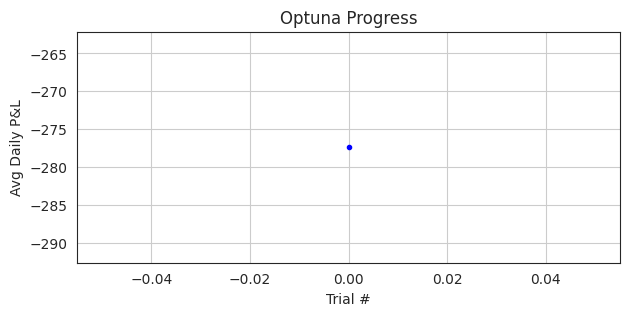

[Results] mean_pnl:-276.9484   mean_excess:-277.3888    improv:-62978.03%     
best trias is:0 with best_val:-277.3888
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_thresh=31.00000, atr_mult=7.99041, vwap_atr_mult=-6.52711, invest_frac=0.01196, buy_factor=0.77105, sell_factor=0.54210, trailstop_pct=13.20200, sess_start=13:30:00


Trial 1:  91%|█████████ | 204/225 [00:41<00:04,  4.85it/s]

In [ ]:
# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
trials_before_pruning = 70
trials_of_exploration = 100
n_jobs = 1 # must be always 1, otherwise global variables don´t reset correctly ?

reports_per_trial = math.ceil(len(groups) / report_interval) # at least 30% of days to execute before pruning
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

start = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
end   = df.loc[df.index.normalize() == df.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

def short_log_callback(study, trial):
    val = trial.value # mean_excess
    mean_pnl = trial.user_attrs["mean_pnl"]
    mean_bh_pnls = trial.user_attrs["mean_bh_pnls"]
    pct_improv = val / mean_bh_pnls * 100
    print(f"[Results] mean_pnl:{mean_pnl:.4f}   mean_excess:{val:.4f}    improv:{pct_improv:.2f}% \
    \nbest trias is:{study.best_trial.number} with best_val:{study.best_value:.4f}")

sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42
pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=trials_before_pruning, n_warmup_steps=n_warmup_steps)

study = optuna.create_study(
    sampler=sampler,
    pruner=pruner,
    # storage=None,
    load_if_exists=True,
    direction="maximize",
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df.index.normalize().min().strftime("%Y%m%d")
last_day  = df.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")